In [ ]:
!nvidia-smi

Wed Sep 30 12:15:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   7928MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Dataset/chest_xray/train'
valid_path = '/content/drive/My Drive/Dataset/chest_xray/test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Dataset/chest_xray/train/*')
folders

['/content/drive/My Drive/Dataset/chest_xray/train/PNEUMONIA',
 '/content/drive/My Drive/Dataset/chest_xray/train/NORMAL']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Dataset/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Dataset/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
326/326 [==============================] - 5646s 17s/step - loss: 0.7308 - accuracy: 0.7891 - val_loss: 0.5637 - val_accuracy: 0.7901
Epoch 2/10
326/326 [==============================] - 138s 424ms/step - loss: 0.3990 - accuracy: 0.8612 - val_loss: 1.9328 - val_accuracy: 0.6346
Epoch 3/10
326/326 [==============================] - 138s 424ms/step - loss: 0.3827 - accuracy: 0.8700 - val_loss: 1.2383 - val_accuracy: 0.6859
Epoch 4/10
326/326 [==============================] - 135s 415ms/step - loss: 0.3928 - accuracy: 0.8742 - val_loss: 1.3363 - val_accuracy: 0.6955
Epoch 5/10
326/326 [==============================] - 134s 412ms/step - loss: 0.4454 - accuracy: 0.8671 - val_loss: 0.6572 - val_accuracy: 0.8253
Epoch 6/10
326/326 [==============================] - 134s 411ms/step - loss: 0.4727 - accuracy: 0.8721 - val_loss: 0.4556 - val_accuracy: 0.8462
Epoch 7/10
326/326 [==============================] - 132s 406ms/step - loss: 0.4095 - accuracy: 0.8911 - val_loss: 1.3533 - 

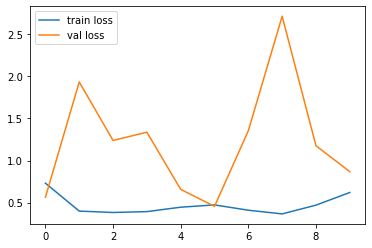

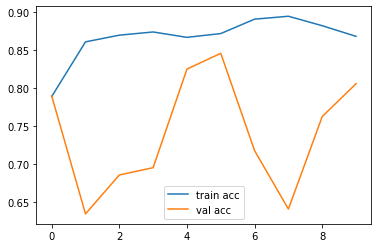

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:

# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/My Drive/Dataset/pnumonia_resnet.h5')

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np 
model = load_model('/content/drive/My Drive/Dataset/pnumonia_resnet.h5')

In [ ]:
img = image.load_img('/content/drive/My Drive/Dataset/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg', target_size=(224, 224)) #insert a random covid-19 x-ray image
#imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: normal')
else:
  print('Prediction: pnumonia')

Prediction: pnumonia


In [ ]:
img = image.load_img('/content/drive/My Drive/Dataset/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', target_size=(224, 224)) #insert a random covid-19 x-ray image
#imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: normal')
else:
  print('Prediction: pnumonia')

Prediction: normal
